# A Brief explaination of GWcosmo

GWcosmo is a package used to estimate the Hubble constant with gravitational-wave observations. GWcosmo can estimate the Hubble constant with three settings:

* With an indentified galaxy for the GW identified

* With a galaxy catalogue (we do not know the hosting galaxy)

* With an empty galaxy catalogue, just by using the masses of the GW event, see later

In this notebook we will present a tutorial on how to use GWcosmo to measure the Hubble constant from GW170817 with its associated EM counterpart.  I will show you how to handle the ingredients which are necessary for the analysis.
For an in depth description of the statistical method behind GWcosmo check this [paper](https://arxiv.org/abs/1908.06050).

## The method behind GWcosmo

We use the Bayes theorem to write down the posterior on the Hubble consant.

$$p(H_0|x)=\frac{p(x|H_0)p(H_0)}{\beta(H_0)}$$,

where 

$$p(H_0|x)\propto \frac{p(H_0)}{\beta(H_0)} \int_{z,m_{1,s},m_{2,s}} p(x|z,m_{1,s},m_{2,s},H_0) p(m_{1,s},m_{2,s}) p(z) \, dz dm_{1,s} dm_{2,s}$$

where 

* $p(x|z,m_{1,s},m_{2,s},H_0)$ is the GW likelihood expressed in terms of redshift, source-frame masses and Hubble constant
* $ p(z)$ and $p(m_{1,s},m_{2,s})$ are the redshift and masses priors that we assume in our analysis. Note that these priors should match with the population you are looking at, otherwise, due to selection bias, you will get a wrong result on $H_0$.
* $\beta(H_0)$ is a term that takes into account selection biases.






### The selection effect

Let us start by looking at the $\beta(H_0)$ factor. This term is usually not present in classical Bayesian analysis and it represent a normalization factor with respect to a value of $H_0$.

This factor here should be included because this kind of analysis is prone to a **selection bias**, i.e. for some values of $H_0$ GW events are easier to detect. The selection effect can be calulated as

$$ \beta(H_0) = \int p_{\rm det}(z,H_0) p(z) \, dz$$,

in GWcosmo we provide these ingredients


In [3]:
%matplotlib inline
%matplotlib inline
import gwcosmo
import numpy as np
import pkg_resources
import pickle
import os
import matplotlib.pyplot as plt

In [4]:
# Read where gwcosmo is installed and look at the pdet files available
data_path = pkg_resources.resource_filename('gwcosmo', 'data/')
print(data_path)
os.listdir(data_path)

/home/masterjohn/anaconda3/envs/gdrgwcosmo/lib/python3.6/site-packages/gwcosmo-0.1.0-py3.6.egg/gwcosmo/data/


['V1_O2_strain.txt',
 'L1_O5_strain.txt',
 'O3PSD_NSBH_Nsamps20000_full_waveform.p',
 'V1_O4low_strain.txt',
 'O2PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_10.0.p',
 'H1_O5_strain.txt',
 'K1_O5_strain.txt',
 'K1_O4low_strain.txt',
 'L1_O3_strain.txt',
 'V1_O5_strain.txt',
 'H1_O4high_strain.txt',
 'O1PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_10.0.p',
 'L1_O4high_strain.txt',
 'L1_O1_strain.txt',
 'L1_O4low_strain.txt',
 'A+_strain.txt',
 'O1PSD_BBH-powerlaw_alpha_1.0_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_12.0.p',
 'O2PSD_BBH-powerlaw_alpha_2.3_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_12.0.p',
 'O2PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_50.0_Nsamps20000_full_waveform_snr_12.0.p',
 'V1_O4high_strain.txt',
 'O1PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_50.0_Nsamps20000_full_waveform_snr_12.0.p',
 'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p',
 'O1PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_100.0_Nsamp

In [5]:
# Load the detector probability class, it is precomputed from us
pdet = pickle.load(open(data_path+
                        'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p', 'rb'))

Text(0.5, 0, 'z')

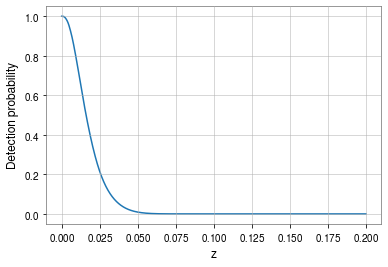

In [6]:
# Let us plot the detection probability
H0 = 70 # Hubble constant in km/Mpc/s
z_array = np.linspace(0,0.2,1000) # Redshift at which you want to evaluate your det. probability
pdet_array = pdet.pD_zH0_eval(z_array,H0) # Use the pdet method to compute pdet
plt.plot(z_array,pdet_array)
plt.ylabel('Detection probability')
plt.xlabel('z')

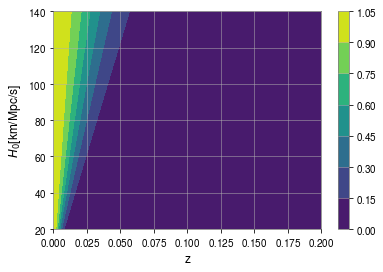

In [7]:
# Here we evaluate pdet over a grid of redshift and H0
H0_array = np.linspace(20,140,100)
pdet_array = pdet.pD_zH0_eval(z_array,H0_array)

zz, hh = np.meshgrid(z_array,H0_array)

plt.contourf(zz,hh,pdet_array)
plt.ylabel(r'$H_0$[km/Mpc/s]')
plt.xlabel('z')
plt.colorbar()

In [8]:
# We import the redshift prior class
from gwcosmo.utilities.standard_cosmology import redshift_prior

Text(0, 0.5, 'pdf')

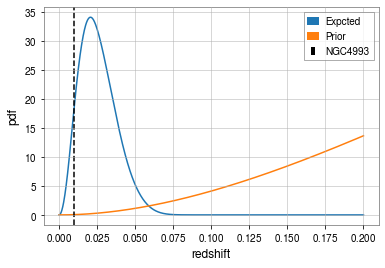

In [9]:
# Here we calculate the expcted detection redshift for BNS in a Universe with H0=70
p_z = redshift_prior()
prior_porb = p_z.p_z(z_array)
prior_porb/=np.trapz(prior_porb,z_array)

# Calculate the expected events in redshift and normalize
det_expected = prior_porb*pdet.pD_zH0_eval(z_array,70)
det_expected /=np.trapz(det_expected,z_array)

plt.plot(z_array,det_expected,label='Expcted')
plt.plot(z_array,prior_porb,label='Prior')
plt.axvline(0.01,label='NGC4993',ls='--',c='k')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('pdf')

Text(0, 0.5, 'Selection bias')

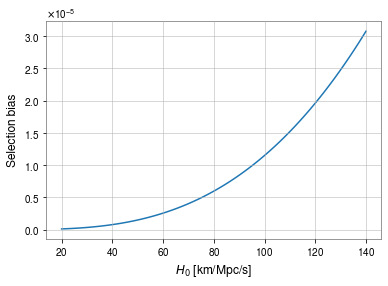

In [10]:
# This is the selection effect

beta = np.zeros_like(H0_array)

for i,H0 in enumerate(H0_array):
    beta[i]=np.trapz(pdet.pD_zH0_eval(z_array,H0)*p_z.p_z(z_array),z_array)

plt.plot(H0_array,beta)
plt.xlabel('$H_0$ [km/Mpc/s]')
plt.ylabel('Selection bias')

In [ ]:
# A block to calculate a pdet class from scratch! It is slow, so I am not going to run it
asd = 'O2' # ASD of the detectors
mmin = 10 # Minimum mass in solar masses
mmax = 40 # Maximum mass in solar masses
mass_distribution = 'BBH-powerlaw' # Masses distribution, see mass_distribution class in prior module
alpha = 2 # Powerlaw slope for BBHs mass distribution
Nsamps = 5000 #How many injection per H0,z bin
network_snr_threshold = 12 # SNR threshold for detection 
kind = 'full_waveform' # Kind of injections, use full waveforms with IMRPhenomPv2

H0 = np.linspace(20,140,100) # H0 at which you want to calculate
pdet = gwcosmo.detection_probability.DetectionProbability(mass_distribution=mass_distribution, alpha=alpha,
                                                          asd=asd,full_waveform=kind,H0=H0,network_snr_threshold=network_snr_threshold)


### The gravitational wave likelihood

The gravitavitational-wave likelihood is not something that we are provided with. The LVC provides us with a set of posterior samples on the luminosity distance of the source and their detected masses in DETECTOR FRAME. Note that $m_d = (1+z) m_s$.

In this sense we are not provided with $p(x|z,H_0,m_{1,s},m_{2,s})$. So we are going to use the Bayes theorem and write

$$ p(x|z,H_0,m_{1,s},m_{2,s}) \propto \frac{p(z,m_{1,s},m_{2,s}|x,H_0)}{\pi(z,m_{1,s},m_{2,s}|H_0)} $$,

where the numerator can be computed starting from the posterior samples, while the term $\pi(z,m_{1,s},m_{2,s}|H_0)$ is the prior used by the LVC to produce posterior samples. The LVC put uniform priors in detector frame masses and a squared prior on the luminosity distance, so the above Eq can be rewritten as

$$ p(x|z,H_0,m_{1,s},m_{2,s}) \propto \frac{p(z,m_{1,s},m_{2,s}|x,H_0)}{|J| d^2_L(z,H0) } $$,

where $|J|$ is the determinant of the Jacobian of the transformation from detector frame to source frame.


In [11]:
from gwcosmo.likelihood.posterior_samples import posterior_samples
import corner.corner

# Uncomment below to download GW170817 posterior samples

#!wget https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5

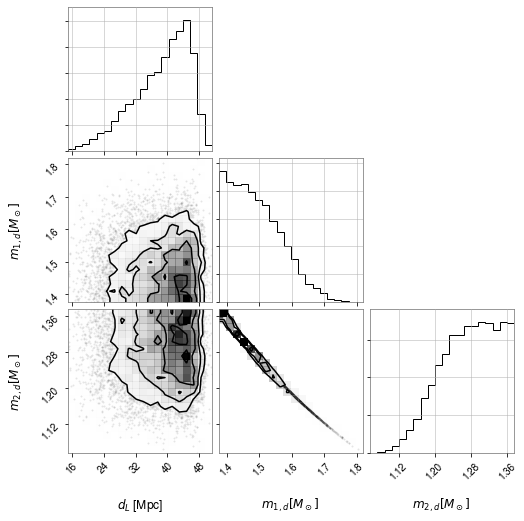

In [12]:
# Load the posterior samples. Currently we support hdf5 from GWTC-1 and h5 from GWTC-2.
GW170817 = posterior_samples('GW170817_GWTC-1.hdf5')

# Plots in detector frame
to_plot = np.column_stack([GW170817.distance,GW170817.mass_1,GW170817.mass_2])
_ = corner.corner(to_plot,labels=[r'$d_L$ [Mpc]', r'$m_{1,d} [M_\odot]$ ',r'$m_{2,d} [M_\odot]$ '])



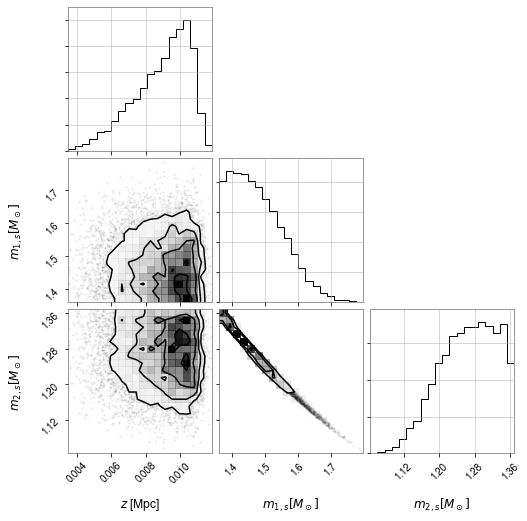

In [13]:
# Plots in source frame
redshift, mass_1_source, mass_2_source = GW170817.compute_source_frame_samples(70)
to_plot = np.column_stack([redshift,mass_1_source,mass_2_source])
_ = corner.corner(to_plot,labels=[r'$z$ [Mpc]', r'$m_{1,s} [M_\odot]$ ',r'$m_{2,s} [M_\odot]$ '])


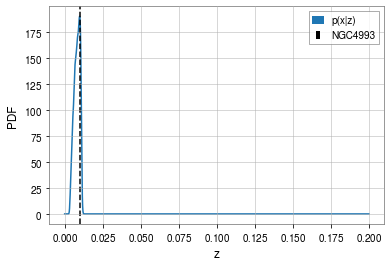

In [14]:
z_likelihood = GW170817.marginalized_redshift_reweight(70,'BNS')[0]
plt.plot(z_array,z_likelihood(z_array),label=r'p(x|z)')
plt.xlabel('z')
plt.ylabel('PDF')
plt.axvline(0.01,ls='--',c='k',label='NGC4993')
plt.legend()

## Let's do the analysis now


In [15]:
import gwcosmo
from astropy.constants import c
from tqdm import tqdm

H0_array = np.linspace(20,200,100) # Define the H0 for the analysis

# Load posterior samples
samples = gwcosmo.likelihood.posterior_samples.posterior_samples('GW170817_GWTC-1.hdf5')
posterior = np.ones_like(H0_array)

# Load pdet
pdet = pickle.load(open(data_path+
                        'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p', 'rb'))

cval = c.to('km/s').value

#Create redshift samples from NGC4993
z_array = np.linspace(0,0.2,1000)
z_NGC4993 = np.random.randn(500)*150+3017
z_NGC4993/=cval

# The redshift prior
p_z = redshift_prior()


for i,H0 in tqdm(enumerate(H0_array)):
    
    # Calculate selection effect
    beta =np.trapz(pdet.pD_zH0_eval(z_array,H0)*p_z.p_z(z_array),z_array)
    
    # Calculate the redshift kernel for the GW part
    z_likelihood, ww = samples.marginalized_redshift_reweight(H0,'BNS')
    
    # Marginalize over redshift
    posterior[i]=np.sum(z_likelihood(z_NGC4993)*p_z.p_z(z_NGC4993))*ww/beta
    
# Normalize
posterior/=np.trapz(posterior,H0_array)
    



100it [01:09,  1.42it/s]


Text(0, 0.5, 'PDF')

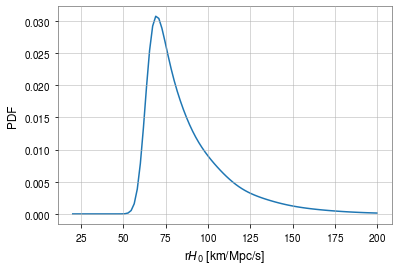

In [16]:
plt.plot(H0_array,posterior)
plt.xlabel('r$H_0$ [km/Mpc/s]')
plt.ylabel('PDF')